#Анализ данных

##Описание источника

Датасет сформирован из набора фотографий итогов проведение планово-профилактических работ на объектах связи

Извлекались фотографии на которых зафиксирован общий вид мест размещения телекоммуникационных шкафов исключительно в закрытом состоянии, отсальные снимки в расчет не берем

Далее с помощью "написать ПО" по каждой фотографии подготовлены аннотации содержащие
- bounding box в котором присутствуют исследуемые объекты
- описание типа шкафа
- дополнительные признаки


После первого этапа EDA были выявлены ряд проблем всвязи с чем проведены следующие доработки
- увеличен датасет до 900+ фотографий
- при увеличении датасета особый упор был на дополнение классов с малым количеством объектов
- проведена проверка корректности формирования аннотаций в частности смещение BB по ряду фотографий
- устранен класс unknown указанием корректного

##Шаг 1: Подготовка среды и загрузка данных

Библиотеки:


In [ ]:
import os
import xml.etree.ElementTree as ET
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob

Dataset:

In [ ]:
!git clone https://github.com/torpedonosec80/object_foto_dataset.git

Cloning into 'object_foto_dataset'...
remote: Enumerating objects: 23601, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 23601 (delta 26), reused 28 (delta 25), pack-reused 23570 (from 2)
Receiving objects: 100% (23601/23601), 400.60 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (15364/15364), done.
Updating files: 100% (6604/6604), done.


Структура данных:

проверим количество фотографий и аннотаций к ним

In [ ]:
# images_dir = '/content/object_foto_dataset/dataset_foto_boxes/images'
# annotations_dir = '/content/object_foto_dataset/dataset_foto_boxes/annotations_xml'

dataset_dir = '/content/object_foto_dataset/boxes_dataset'

image_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.JPG')])
annotation_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.xml')])

print(f"Найдено изображений: {len(image_files)}")
print(f"Найдено аннотаций: {len(annotation_files)}")

Найдено изображений: 935
Найдено аннотаций: 935


количество изображений и аннотаций совпадает

*общее количество фотографий не велико, возможность увеличения набора данных будет дополнительной задачей с учетом результатов исследования датасета и появления возможных замечаний*

##Шаг 2: Проверка согласованности данных

In [ ]:
# Проверка соответствия имен файлов
image_basenames = {os.path.splitext(f)[0] for f in image_files}
annotation_basenames = {os.path.splitext(f)[0] for f in annotation_files}

missing_images = annotation_basenames - image_basenames
missing_annotations = image_basenames - annotation_basenames

print(f"Аннотации без изображений: {len(missing_images)}")
print(f"Изображения без аннотаций: {len(missing_annotations)}")

Аннотации без изображений: 0
Изображения без аннотаций: 0


In [ ]:
missing_images

set()

In [ ]:
missing_annotations

set()

для всех фотографий есть аннотации

##Шаг 3: Анализ аннотаций

a) Парсинг XML:

In [ ]:
rows = []
anns   = glob(os.path.join(dataset_dir, '*.xml'))
for xml_file in anns:
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Имя изображения
        filename_tag = root.find('filename')
        if filename_tag is None or filename_tag.text is None:
            print(f"[!] Нет имени изображения: {xml_file}")
            continue

        img_name = filename_tag.text.strip()
        img_path = os.path.join(dataset_dir, img_name)
        if not os.path.exists(img_path):
            print(f"[!] Изображение не найдено: {img_path}")
            continue

        # Получаем размер изображения напрямую
        with Image.open(img_path) as img:
            w, h = img.size

        for obj in root.findall('object'):
            cls = obj.find('name')
            bbox = obj.find('bndbox')
            if cls is None or bbox is None:
                continue

            xmin = bbox.find('xmin')
            ymin = bbox.find('ymin')
            xmax = bbox.find('xmax')
            ymax = bbox.find('ymax')

            if None in (xmin, ymin, xmax, ymax):
                continue

            rows.append({
                'image': img_name,
                'class': cls.text,
                'img_w': w,
                'img_h': h,
                'xmin': int(xmin.text),
                'ymin': int(ymin.text),
                'xmax': int(xmax.text),
                'ymax': int(ymax.text)
            })

    except Exception as e:
        print(f"[!] Ошибка в {xml_file}: {e}")

df = pd.DataFrame(rows)
df['bbox_w'] = df['xmax'] - df['xmin']
df['bbox_h'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_w'] * df['bbox_h']
print(f"Объектов загружено: {len(df)}")
df.head()


Объектов загружено: 1036


,image,class,img_w,img_h,xmin,ymin,xmax,ymax,bbox_w,bbox_h,bbox_area
0,image_images_0153.jpg,shta-9m,2736,3648,1084,827,2269,2029,1185,1202,1424370
1,additional_e2_6u_36.jpeg,e2-6u,1024,768,366,111,730,308,364,197,71708
2,image_e2_6u_0019.jpeg,e2-6u,1024,576,234,130,761,460,527,330,173910
3,additional_shta_9_35.jpg,shta-9,1200,1600,428,430,954,984,526,554,291404
4,image_e2_6u_0026.jpeg,e2-6u,1024,473,173,37,848,468,675,431,290925


b) Анализ объектов:



In [ ]:
df.groupby("class")['image'].agg('count').reset_index()

,class,image
0,e2-6u,121
1,shta-3,192
2,shta-7m,160
3,shta-9,159
4,shta-9m,150
5,shta-ps,126
6,sv-5,128


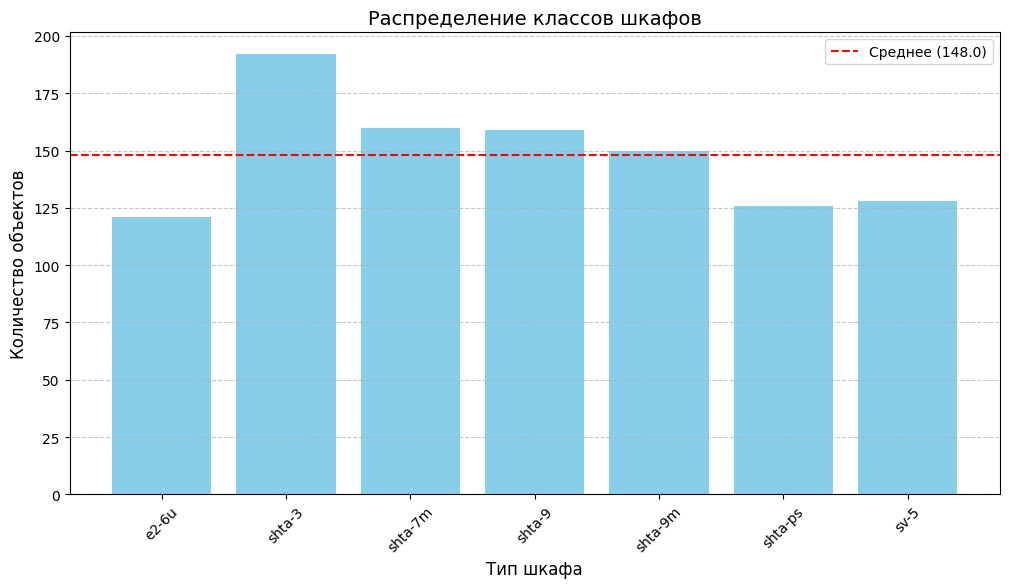

In [ ]:
classes = list(df.groupby("class")['image'].agg('count').reset_index()['class'])
counts  = list(df.groupby("class")['image'].agg('count').reset_index()['image'])

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.axhline(y=sum(counts)/len(counts), color='r', linestyle='--', label=f'Среднее ({sum(counts)/len(counts):.1f})')
plt.title('Распределение классов шкафов', fontsize=14)
plt.xlabel('Тип шкафа', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Анализ распределения классов (типов шкафов)

1. Дисбаланс классов

дисбалланс устранен, всего 3 класса представлены меньше среднего но разницу можем считать не значительной

2. Класс unknown

устранен. аннотация скорректирована к корректному классу

3. Достаточность данных

количество объектов увеличено с 436 до 1000+

Все необходимые мероприятия выполнены

## Шаг 4: Размеры BBox


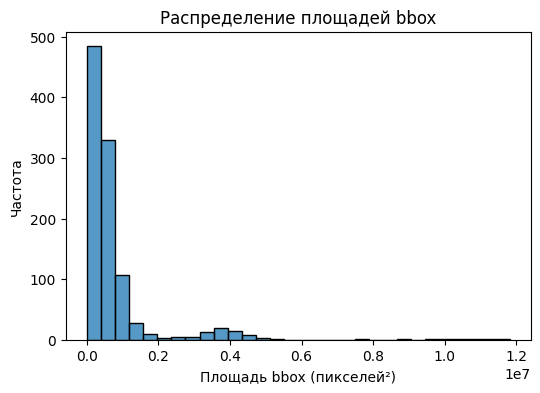

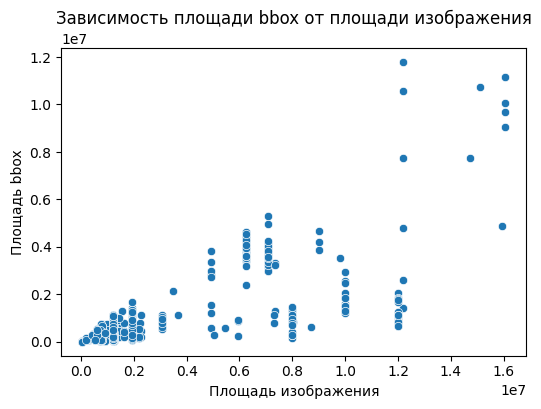

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['bbox_area'], bins=30)
plt.title("Распределение площадей bbox")
plt.xlabel("Площадь bbox (пикселей²)")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=df['img_w']*df['img_h'], y=df['bbox_area'])
plt.title("Зависимость площади bbox от площади изображения")
plt.xlabel("Площадь изображения")
plt.ylabel("Площадь bbox")
plt.show()


**Что показывает гистограмма:**

Сильная концентрация bbox с малой площадью:
- Подавляющее большинство объектов имеет площадь менее 2 × 10⁶ пикселей²
- Это значит, что объекты в основном небольшие по размеру относительно всего изображения

Длинный правый хвост:
- Есть немного bbox с очень большой площадью (до 10⁷ пикселей²)
- Эти случаи — близко снятые шкафы



**причины разброса:**
- Разный масштаб съёмки (разные расстояния до объекта)
- Разные типы шкафов (размер зависит от модели)
- Частичные аннотации (например, если размечена только часть объекта)



## Шаг 5: Проверка ошибок и аномалий

In [ ]:
invalid = df[(df['xmin']<0) | (df['ymin']<0) |
             (df['xmax']>df['img_w']) | (df['ymax']>df['img_h'])]
print("Найдено некорректных bbox:", len(invalid))
small_boxes = df[df['bbox_area']<10]
large_boxes = df[df['bbox_area']>0.9*df['img_w']*df['img_h']]
print("Очень маленьких bbox:", len(small_boxes))
print("Очень больших bbox:", len(large_boxes))

Найдено некорректных bbox: 0
Очень маленьких bbox: 0
Очень больших bbox: 8


1. Некорректные bbox: 0
    
    проблемы были устранены

2. Очень маленькие bbox: 0
    
    проблемы были устранены

3. Очень большие bbox: 8

    по всем большим BB это такой ракурс съемки, оставляем

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

def show_bbox(df_subset, num_images=5):
    for idx, row in df_subset.head(num_images).iterrows():
        img_path = os.path.join(dataset_dir, row['image'])
        if not os.path.exists(img_path):
            print(f"Файл не найден: {img_path}")
            continue

        img = Image.open(img_path)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        rect = patches.Rectangle(
            (row['xmin'], row['ymin']),
            row['xmax'] - row['xmin'],
            row['ymax'] - row['ymin'],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        ax.set_title(f"{row['image']} | class: {row['class']}")
        plt.axis('off')
        plt.show()


In [ ]:
invalid

,image,class,img_w,img_h,xmin,ymin,xmax,ymax,bbox_w,bbox_h,bbox_area


In [ ]:
show_bbox(invalid, num_images=5)

не корректные BB устранены

In [ ]:
show_bbox(large_boxes, num_images=8)

Output hidden; open in https://colab.research.google.com to view.

На этих примерах наблюдаем фотографии где из-за ракурса съемки BB занимает всю площадь фотографии не охватывая при этом весь исследуемый элемент

Количество не велико, оставляем

В ходе работ с моделями была обнаружена особенность - после загрузки фото в github некоторые фотографии меняли свою ориентацию с альбомной на книжную или наоборот, в итоге по таким фотографиям аннотации были не корректны (выходили за рамки изображения или просто не совпадали с объектом)
для решения выполнено два мероприятия
- с помощью Pillow зафиксировали ориентацию
- прошли по всем аннотациям с помощью labelimg и добавили параметры размеров фотографии к которым выполнены аннотации

соответственно для валидации что все изображения и аннотации теперь выполнены и загружены в git корректно требуется еще один этап **проверки**


In [ ]:
import os
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from PIL import Image

dataset_dir = '/content/object_foto_dataset/boxes_dataset'
rows = []
anns = glob(os.path.join(dataset_dir, '*.xml'))
rotation_issues = []  # Для сбора информации о проблемных изображениях

for xml_file in anns:
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Имя изображения
        filename_tag = root.find('filename')
        if filename_tag is None or filename_tag.text is None:
            print(f"[!] Нет имени изображения: {xml_file}")
            continue

        img_name = filename_tag.text.strip()
        img_path = os.path.join(dataset_dir, img_name)
        if not os.path.exists(img_path):
            print(f"[!] Изображение не найдено: {img_path}")
            continue

        # Размеры из аннотации
        size_tag = root.find('size')
        if size_tag is not None:
            ann_width = int(size_tag.find('width').text)
            ann_height = int(size_tag.find('height').text)
        else:
            ann_width, ann_height = None, None
            print(f"[!] В аннотации {xml_file} отсутствует тег <size>")

        # Реальные размеры изображения
        with Image.open(img_path) as img:
            real_width, real_height = img.size

        # Проверка на поворот/несоответствие размеров
        if ann_width is not None and ann_height is not None:
            if (real_width, real_height) not in [(ann_width, ann_height), (ann_height, ann_width)]:
                rotation_issues.append({
                    'image': img_name,
                    'real_width': real_width,
                    'real_height': real_height,
                    'ann_width': ann_width,
                    'ann_height': ann_height
                })

        # Парсинг объектов
        for obj in root.findall('object'):
            cls = obj.find('name')
            bbox = obj.find('bndbox')
            if cls is None or bbox is None:
                continue

            xmin = bbox.find('xmin')
            ymin = bbox.find('ymin')
            xmax = bbox.find('xmax')
            ymax = bbox.find('ymax')

            if None in (xmin, ymin, xmax, ymax):
                continue

            rows.append({
                'image': img_name,
                'class': cls.text,
                'img_w': real_width,    # Используем реальные размеры
                'img_h': real_height,
                'ann_width': ann_width, # Размеры из аннотации
                'ann_height': ann_height,
                'xmin': int(xmin.text),
                'ymin': int(ymin.text),
                'xmax': int(xmax.text),
                'ymax': int(ymax.text)
            })

    except Exception as e:
        print(f"[!] Ошибка в {xml_file}: {e}")

# Создаем DataFrame
df = pd.DataFrame(rows)
if not df.empty:
    df['bbox_w'] = df['xmax'] - df['xmin']
    df['bbox_h'] = df['ymax'] - df['ymin']
    df['bbox_area'] = df['bbox_w'] * df['bbox_h']
print(f"Объектов загружено: {len(df)}")

# Анализ проблемных изображений
if rotation_issues:
    print("\n[!] Найдены несоответствия размеров в изображениях:")
    issues_df = pd.DataFrame(rotation_issues)
    display(issues_df)

    # Группируем по изображениям (если несколько объектов в одном файле)
    summary = issues_df.groupby('image').first().reset_index()
    print(f"\nКоличество проблемных изображений: {len(summary)}")
    for _, row in summary.iterrows():
        print(
            f"Изображение: {row['image']}\n"
            f"  Реальные размеры: {row['real_width']}x{row['real_height']}\n"
            f"  Размеры в аннотации: {row['ann_width']}x{row['ann_height']}"
        )
else:
    print("\n[OK] Все изображения соответствуют размерам в аннотациях")

Объектов загружено: 1036

[OK] Все изображения соответствуют размерам в аннотациях


# Заключение по итогам EDA

- после первого этапа анализа данных провели ряд действий в результате чего все мешающие дефекты данных устранены

- на базе опыта обучения моделей выявили дополнительные проблемы и их так же устранили

----